<a href="https://colab.research.google.com/github/lrodrigocareaga/practice/blob/master/housesRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras,os,tarfile,sys,pickle,zipfile

#Keras libraries & packages
from keras import models,initializers,layers,optimizers
from keras import backend as K
from keras.utils import to_categorical,plot_model
from keras.models import Sequential,Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D,advanced_activations,Flatten,concatenate,Dropout,MaxPooling2D,Activation,GlobalAveragePooling2D,BatchNormalization,SeparableConv2D,SpatialDropout2D,LeakyReLU
from keras.callbacks import EarlyStopping

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

#Sci-kit libraries
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

#Others
import time
import matplotlib.image as mpimg
import skimage
import argparse
import locale
import sklearn.model_selection
import cv2
import shapely.wkt
import shapely.affinity
import seaborn as sns
from skimage.io import imshow
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads

In [3]:
# Establish the home directory
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


## Kaggle Import

In [5]:
#import kaggle.json
from google.colab import files
files.upload()

{}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [7]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json


!pip install -q kaggle
!pip install -q kaggle-cli

#see the possible datasets in kaggle
!kaggle datasets list
#see the possible competitions in kaggle
!kaggle competitions list

total 4
-rw------- 1 root root 70 May  5 19:54 kaggle.json
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 5.3MB 17.6MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 102kB 38.0MB/s 
ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          40533  
bigquery/crypto-ethereum-classic                             Ethereum Classic Blockchain                          70GB  2019-03-20 23:21:25              0  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2

In [15]:
os.chdir('/content/drive/My Drive/casas/casasBoston')
!kaggle competitions list -c house-prices-advanced-regression-techniques
!kaggle competitions download -c boston-housing


usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: unrecognized arguments: -c house-prices-advanced-regression-techniques
  0% 0.00/23.6k [00:00<?, ?B/s]
100% 23.6k/23.6k [00:00<00:00, 3.35MB/s]
  0% 0.00/11.5k [00:00<?, ?B/s]
100% 11.5k/11.5k [00:00<00:00, 1.64MB/s]
  0% 0.00/3.52k [00:00<?, ?B/s]
100% 3.52k/3.52k [00:00<00:00, 504kB/s]


In [0]:
os.chdir('/content/drive/My Drive/')
for file in os.listdir():
  if file.endswith("csv.zip"):
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [0]:
import zipfile
zip_ref = zipfile.ZipFile('deepsat-sat6.zip', 'r')
zip_ref.extractall()
zip_ref.close()

## Github Download dataset

In [27]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2161, done.
remote: Total 2161 (delta 0), reused 0 (delta 0), pack-reused 2161
Receiving objects: 100% (2161/2161), 176.26 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Checking out files: 100% (2144/2144), done.


# Experiments

## Load Data

In [0]:
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
df = pd.read_csv('/content/drive/My Drive/casas/casasBoston/Houses-dataset/Houses Dataset/HousesInfo.txt', sep=" ", header=None, names=cols)

In [29]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500.0
1,4,3.0,3343,36372,865200.0
2,3,4.0,3923,85266,889000.0
3,5,5.0,4022,85262,910000.0
4,3,4.0,4116,85266,971226.0


In [0]:
zipcodes = df["zipcode"].value_counts().keys().tolist()
counts = df["zipcode"].value_counts().tolist()

In [0]:
for (zipcode, count) in zip(zipcodes, counts):
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)

In [0]:
(train, test) = train_test_split(df, test_size=0.25, random_state=42)

In [45]:
continuous = ["bedrooms", "bathrooms", "area"]
 
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(train[continuous])
testContinuous = cs.transform(test[continuous])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
zipBinarizer = LabelBinarizer().fit(df["zipcode"])
trainCategorical = zipBinarizer.transform(train["zipcode"])
testCategorical = zipBinarizer.transform(test["zipcode"])

trainX = np.hstack([trainCategorical, trainContinuous])
testX = np.hstack([testCategorical, testContinuous])

In [0]:
maxPrice = train["price"].max()
trainY = train["price"] / maxPrice
testY = test["price"] / maxPrice

## Dense Neural Network for Regression

In [0]:
model1 = Sequential()
model1.add(Dense(8, input_dim=trainX.shape[1], activation="relu"))
model1.add(Dense(4, activation="relu"))
model1.add(Dense(1, activation="linear"))

In [112]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model1.compile(optimizer='adam', loss="mean_absolute_percentage_error")


start = time.clock() 

history = model1.fit(trainX, trainY, 
                    validation_data=(testX, testY),
                    epochs=200, 
                    batch_size=16)
end = time.clock()
timeDense = end-start

print("Total Time: {} ".format(timeDense)) 

Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 1s 4ms/step - loss: 410.2364 - val_loss: 281.4753
Epoch 2/200
271/271 [==============================] - 0s 266us/step - loss: 215.8306 - val_loss: 138.2611
Epoch 3/200
271/271 [==============================] - 0s 236us/step - loss: 111.9359 - val_loss: 101.3591
Epoch 4/200
271/271 [==============================] - 0s 238us/step - loss: 82.8506 - val_loss: 79.2888
Epoch 5/200
271/271 [==============================] - 0s 259us/step - loss: 63.0408 - val_loss: 56.0147
Epoch 6/200
271/271 [==============================] - 0s 293us/step - loss: 48.4255 - val_loss: 48.3165
Epoch 7/200
271/271 [==============================] - 0s 280us/step - loss: 44.1800 - val_loss: 44.7328
Epoch 8/200
271/271 [==============================] - 0s 241us/step - loss: 40.3557 - val_loss: 41.8082
Epoch 9/200
271/271 [==============================] - 0s 264us/step - loss: 38.3300 - val_loss: 39.9685
Epoch 

In [113]:
test_lossDense = model1.evaluate(testX, testY)

preds = model1.predict(testX)

91/91 [==============================] - 0s 118us/step


In [0]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [0]:
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [71]:
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(locale.currency(df["price"].mean(), grouping=True),locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 21.05%, std: 22.13%


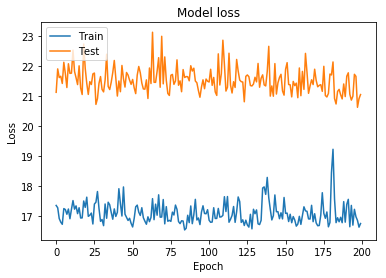

In [73]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## CNN with Images

In [0]:
inputPath = '/content/drive/My Drive/casas/casasBoston/Houses-dataset/Houses Dataset/'
images = []

for i in df.index.values:
  basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
  housePaths = sorted(list(glob.glob(basePath)))
  inputImages = []
  outputImage = np.zeros((64, 64, 3), dtype="uint8")
  
  for housePath in housePaths:
    image = cv2.imread(housePath)
    image = cv2.resize(image, (32, 32))
    inputImages.append(image)

  outputImage[0:32, 0:32] = inputImages[0]
  outputImage[0:32, 32:64] = inputImages[1]
  outputImage[32:64, 32:64] = inputImages[2]
  outputImage[32:64, 0:32] = inputImages[3]
  images.append(outputImage)

In [0]:
images = np.array(images)
images = images/255.0

In [0]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

In [0]:
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [0]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):

	inputShape = (height, width, depth)
	chanDim = -1

	inputs = Input(shape=inputShape)

	for (i, f) in enumerate(filters):
		if i == 0:
			x = inputs

		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)

	x = Dense(4)(x)
	x = Activation("relu")(x)

	if regress:
		x = Dense(1, activation="linear")(x)

	model = Model(inputs, x)

	return model

In [0]:
model2 = create_cnn(64, 64, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)
model2.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [169]:
history2 = model2.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),epochs=200, batch_size=8)

Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 4s 14ms/step - loss: 1551.8885 - val_loss: 814.8942
Epoch 2/200
271/271 [==============================] - 0s 1ms/step - loss: 887.2231 - val_loss: 672.2385
Epoch 3/200
271/271 [==============================] - 0s 1ms/step - loss: 624.3974 - val_loss: 671.6264
Epoch 4/200
271/271 [==============================] - 0s 1ms/step - loss: 569.9937 - val_loss: 536.8730
Epoch 5/200
271/271 [==============================] - 0s 1ms/step - loss: 436.3897 - val_loss: 376.4310
Epoch 6/200
271/271 [==============================] - 0s 1ms/step - loss: 475.2227 - val_loss: 231.9366
Epoch 7/200
271/271 [==============================] - 0s 1ms/step - loss: 356.7876 - val_loss: 228.1142
Epoch 8/200
271/271 [==============================] - 0s 1ms/step - loss: 304.4992 - val_loss: 106.0673
Epoch 9/200
271/271 [==============================] - 0s 1ms/step - loss: 270.6245 - val_loss: 215.8803
Epoch 10

In [0]:
preds = model2.predict(testImagesX)

In [0]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [0]:
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [173]:
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 52.94%, std: 91.42%


## Combine the models

In [123]:
continuous = ["bedrooms", "bathrooms", "area"]
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(train[continuous])
testContinuous = cs.transform(test[continuous])

zipBinarizer = LabelBinarizer().fit(df["zipcode"])
trainCategorical = zipBinarizer.transform(train["zipcode"])
testCategorical = zipBinarizer.transform(test["zipcode"])

trainX = np.hstack([trainCategorical, trainContinuous])
testX = np.hstack([testCategorical, testContinuous])

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
inputPath = '/content/drive/My Drive/casas/casasBoston/Houses-dataset/Houses Dataset/'
images = []

for i in df.index.values:
  basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
  housePaths = sorted(list(glob.glob(basePath)))
  inputImages = []
  outputImage = np.zeros((64, 64, 3), dtype="uint8")
  
  for housePath in housePaths:
    image = cv2.imread(housePath)
    image = cv2.resize(image, (32, 32))
    inputImages.append(image)

  outputImage[0:32, 0:32] = inputImages[0]
  outputImage[0:32, 32:64] = inputImages[1]
  outputImage[32:64, 32:64] = inputImages[2]
  outputImage[32:64, 0:32] = inputImages[3]
  
  images.append(outputImage)

In [0]:
images = np.array(images)
images = images/255.0

In [0]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)


In [0]:
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [0]:
def create_mlp(dim, regress=False):
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))
  
  if regress:
		model.add(Dense(1, activation="linear"))

	return model

In [0]:
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)

combinedInput = concatenate([mlp.output, cnn.output])
 
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
 
modelF = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [149]:
opt = Adam(lr=1e-3, decay=1e-3 / 200)
modelF.compile(loss="mape", optimizer=opt)
 
modelF.fit([trainAttrX, trainImagesX], trainY, validation_data=([testAttrX, testImagesX], testY),epochs=200, batch_size=8)

preds = modelF.predict([testAttrX, testImagesX])

Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 3s 12ms/step - loss: 32.3720 - val_loss: 1110.1322
Epoch 2/200
271/271 [==============================] - 0s 1ms/step - loss: 34.6896 - val_loss: 1062.5939
Epoch 3/200
271/271 [==============================] - 0s 2ms/step - loss: 34.7522 - val_loss: 1014.1627
Epoch 4/200
271/271 [==============================] - 0s 1ms/step - loss: 29.8905 - val_loss: 997.1898
Epoch 5/200
271/271 [==============================] - 0s 1ms/step - loss: 29.0915 - val_loss: 1374.5458
Epoch 6/200
271/271 [==============================] - 0s 1ms/step - loss: 30.7741 - val_loss: 191947.3870
Epoch 7/200
271/271 [==============================] - 0s 1ms/step - loss: 28.9804 - val_loss: 209.5709
Epoch 8/200
271/271 [==============================] - 0s 2ms/step - loss: 33.1930 - val_loss: 169172.7793
Epoch 9/200
271/271 [==============================] - 0s 1ms/step - loss: 26.6814 - val_loss: 516000.2905
Epoch

In [151]:
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
 

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
 
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df["price"].mean(), grouping=True),
    locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 824.61%, std: 2635.13%


# Sources

Source: H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/